## Import Library
- Dataset Link:https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification

In [58]:

# To get multi output in jupyternotebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB2, preprocess_input
from keras.layers import Dense, Dropout ,Flatten
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split


import warnings 
warnings.filterwarnings("ignore")

## Load Dataset

In [2]:
dataset="dataset"
image_dir=Path(dataset)

filepaths=list(image_dir.glob(r"**/*.JPG")) +list(image_dir.glob(r"**/*.PNG"))+list(image_dir.glob(r"**/*.JPEG"))

labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))

filepaths=pd.Series(filepaths,name="filepath").astype(str)
labels=pd.Series(labels,name="label")

image_df=pd.concat([filepaths,labels],axis=1)

image_df["label"].value_counts()


label
diabetic_retinopathy    1098
normal                  1074
cataract                1038
glaucoma                1007
Name: count, dtype: int64

## Data Visualization 

Text(0.5, 1.0, 'normal')

Text(0.5, 1.0, 'diabetic_retinopathy')

Text(0.5, 1.0, 'glaucoma')

Text(0.5, 1.0, 'normal')

Text(0.5, 1.0, 'glaucoma')

Text(0.5, 1.0, 'diabetic_retinopathy')

Text(0.5, 1.0, 'diabetic_retinopathy')

Text(0.5, 1.0, 'normal')

Text(0.5, 1.0, 'normal')

Text(0.5, 1.0, 'normal')

Text(0.5, 1.0, 'normal')

Text(0.5, 1.0, 'diabetic_retinopathy')

Text(0.5, 1.0, 'normal')

Text(0.5, 1.0, 'diabetic_retinopathy')

Text(0.5, 1.0, 'normal')

Text(0.5, 1.0, 'glaucoma')

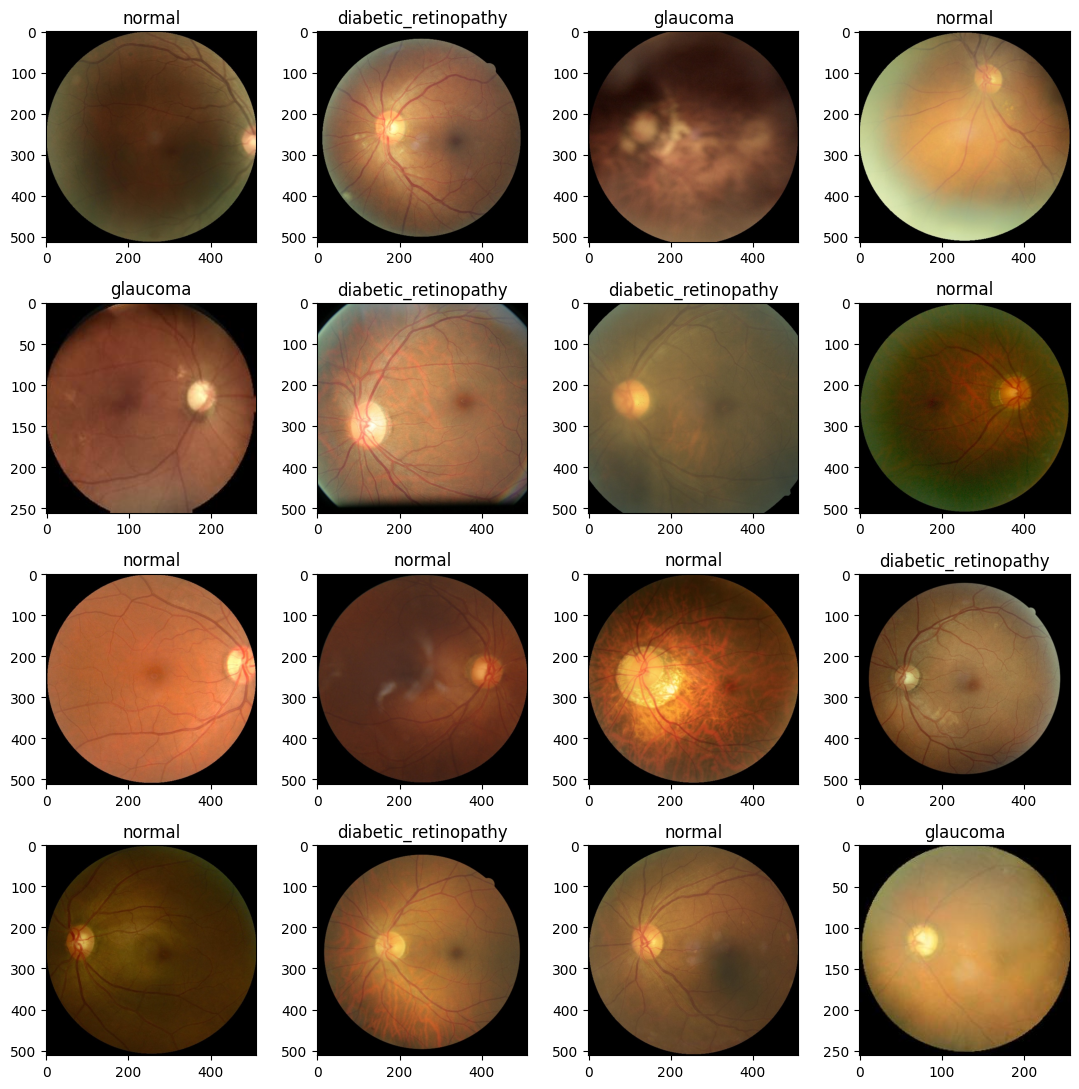

In [3]:
rand_index=np.random.randint(0,len(image_df),16)
fig,axes=plt.subplots(nrows=4,ncols=4,figsize=(11,11))

for i ,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.filepath[rand_index[i]]))
    ax.set_title(image_df.label[rand_index[i]])

plt.tight_layout()

## Data Preprocessing : train-test-split , data augmentation , resize ,rescalling

In [4]:
image_df.shape

(4217, 2)

In [5]:
#train-test-split
train_df,test_df=train_test_split(image_df,test_size=0.2,shuffle=True,random_state=42,stratify=image_df['label'])

In [6]:
# Data Augmentation

train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # EfficientNetB2 için uygun ön işleme
    validation_split=0.2,  # %20 validation set olarak ayrılacak
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input , # Test set için de aynı ön işleme uygulanmalı
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)


In [7]:
train_images=train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(224,224),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=64,
    shuffle=True,
    seed=42,
    subset="training"
) # 4217 x 0.8 x 0.8 = 2699 image

Found 2699 validated image filenames belonging to 4 classes.


In [16]:
test_images=test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(224,224),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=64,
    shuffle=True
) # 4217 x 0.2 lik kısım => 844 image

Found 844 validated image filenames belonging to 4 classes.


In [17]:
val_images=train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(224,224),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=64,
    shuffle=True,
    seed=42,
    subset="validation"
) # 4217 x 0.2 x 0.2 = 674 image

Found 674 validated image filenames belonging to 4 classes.


In [18]:
# resize,rescale
resize_and_rescalling=tf.keras.Sequential(
    [
        layers.Resizing(224, 224),
        layers.Rescaling(1.0 / 255)
    ]
)

## Transfer Learning Model (EfficientNet) , traning

In [19]:
pretrained_model=EfficientNetB2(
    input_shape=(224,224,3), # goruntulerin boyutu (x,x,rgb)
    include_top=False, # son sınıflandırma katmanını dahil etmiyor biz kendimiz paremetreleirni ayarlayacağız
    weights="imagenet", # hangi veri setiyle egitimi
    pooling="avg" # pooling katmanı
)

pretrained_model.trainable=False


In [20]:
checkpoint_path = "checkpoint.weights.h5"  

checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,  
    monitor="val_accuracy",  
    save_best_only=True 
)

early_stopping = EarlyStopping(
    monitor="val_loss",  
    patience=5, 
    restore_best_weights=True
)

In [42]:
print(pretrained_model.input.shape)


(None, 224, 224, 3)


In [44]:
# CLASSIFICATION BLOCK

inputs = pretrained_model.input
x=resize_and_rescalling(inputs) 
# Yeni katmanlar ekle
x = Flatten()(pretrained_model.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)


# Çıkış katmanı
outputs = Dense(4, activation="softmax")(x)

# Modeli oluştur
model = Model(inputs, outputs)


In [45]:
model.compile(optimizer=Adam(0.0001),loss="categorical_crossentropy",metrics=["accuracy"])

history=model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=15,
    callbacks=[early_stopping,checkpoint_callback]
)


Epoch 1/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.3445 - loss: 1.3728 - val_accuracy: 0.5979 - val_loss: 1.0960
Epoch 2/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.5379 - loss: 1.1107 - val_accuracy: 0.6617 - val_loss: 0.8770
Epoch 3/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.6283 - loss: 0.9450 - val_accuracy: 0.6795 - val_loss: 0.7781
Epoch 4/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.6464 - loss: 0.8636 - val_accuracy: 0.7448 - val_loss: 0.6755
Epoch 5/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.6803 - loss: 0.7750 - val_accuracy: 0.7389 - val_loss: 0.6475
Epoch 6/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.7045 - loss: 0.7581 - val_accuracy: 0.7626 - val_loss: 0.6164
Epoch 7/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.7209 - loss: 0.6986 - val_accuracy: 0.7567 - val_loss: 0.5852
Epoch 8/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.7324 - loss: 0.6741 - val_accuracy: 0.7938 - v

## Model Evaluation

In [57]:
results=model.evaluate(test_images,verbose=1)
print(f"test loss : {results[0]}  ,  test accuracy : {results[1]*100}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.7670 - loss: 0.5448
test loss : 0.5197733640670776  ,  test accuracy : 78.55450510978699


<Figure size 1200x500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Training and Validation Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

<Axes: >

Text(0.5, 1.0, 'Training and Validation Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

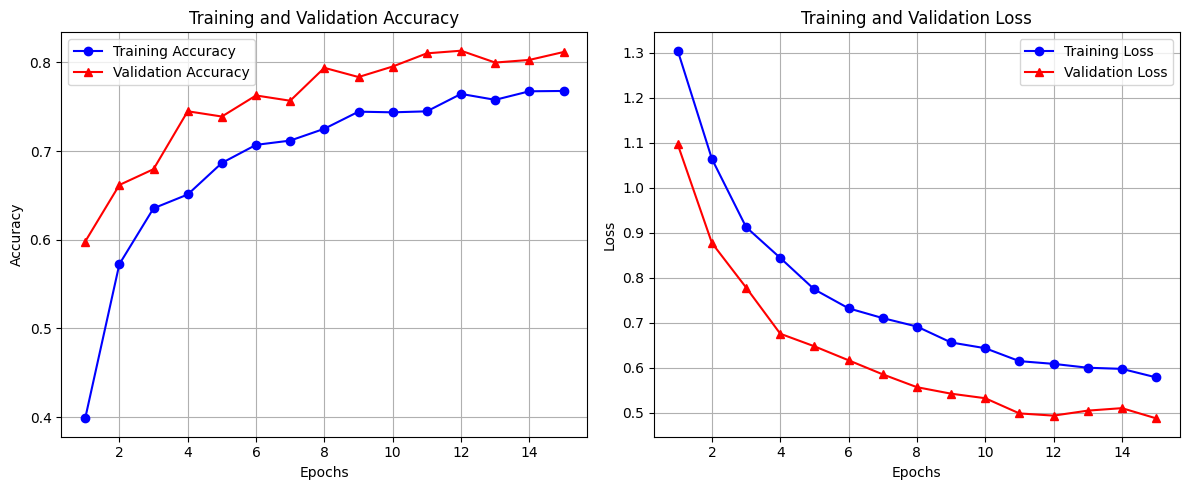

In [47]:
epochs=range(1,len(history.history["accuracy"])+1)
hist=history.history

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs,hist["accuracy"],"bo-",label="Training Accuracy")
plt.plot(epochs,hist["val_accuracy"],"r^-",label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs,hist["loss"],"bo-",label="Training Loss")
plt.plot(epochs,hist["val_loss"],"r^-",label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()